In [162]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from src.baseSIR import no_ext_sir
from src.baseSIR import timed_sir
from decimal import Decimal, ROUND_UP
import time
import pandas as pd

In [145]:
def sum_sq_distance(array1,array2):
    if len(array1) != len(array2):
        raise ValueError("Arrays not of equal length")
    dist = 0
    try:
        x=len(array1[0])
    except:
        for i in range(len(array1)):
            dist += (array1[i] - array2[i])**2
    else:
        for i in range(len(array1)):
            for j in range(len(array1[i])):
                dist += (array1[i][j] - array2[i][j])**2
    return dist

def sum_sqrt_sq_distance(array1,array2):
    if len(array1) != len(array2):
        raise ValueError("Arrays not of equal length")
    dist = 0
    try:
        x=len(array1[0])
    except:
        for i in range(len(array1)):
            dist += (array1[i] - array2[i])**2
    else:
        for i in range(len(array1)):
            for j in range(len(array1[i])):
                dist += (array1[i][j] - array2[i][j])**2
    return np.sqrt(dist)


In [146]:
def ABC_core(func,para_distro,reality,N,distance,rng):
    """
    :param func: The function to iterate over
    :param para_distro: An array of parameter values
    :param N: The number of iterations for each parameter value
    :param distance: The method for choosing a distance measure
    :param rng: RNG
    :return: An array of the parameter values with distance measures
    """

    if distance == "sum_sq":
        dis_func = sum_sq_distance
    elif distance == "sum_sqrt_sq":
        dis_func = sum_sqrt_sq_distance
    else:
        raise ValueError("Not a valid distance measure")
    output = np.array([[0,0]])
    for parameter in para_distro:
        for i in range(N):
            dis = dis_func((func(parameter,rng)),reality)
            out_pair = np.array([parameter,dis])
            output = np.append(output,[out_pair],axis = 0)
    print(".",end="")
    return output[1:]


In [147]:
def test(beta,rng):
    noise = np.random.normal(0,0.2,size = 3)
    return np.array([beta-1 + noise[0],beta + noise[1],beta+1 + noise[2]])

In [ ]:
def ABC_iterate(func,para_distro,reality,N,distance,rng,core_output):
    peak = min(core_output[:,0])
    sorted_output = core_output[core_output[:, 1].argsort()]
    upper = sorted_output[0:len(sorted_output)/5,0]
    new_paras = np.linespace(peak,upper,25)
    return ABC_core(func,new_paras,reality,N,distance,rng)

In [148]:
reality = np.array([2,3,4])
test_paras = np.array([1,2,3,4,5,6,7,8,9,10])

In [149]:
rng = np.random.default_rng(1912)
print(test(4,rng))
print(reality)

[3.2326884  3.78754435 4.94445774]
[2 3 4]


In [150]:
rng = np.random.default_rng(1912)
tested_ABC = ABC_core(test,test_paras,reality,100,"sum_sq",rng=rng)

C:\Users\ollie\AppData\Local\Temp\ipykernel_24680\1166730926.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


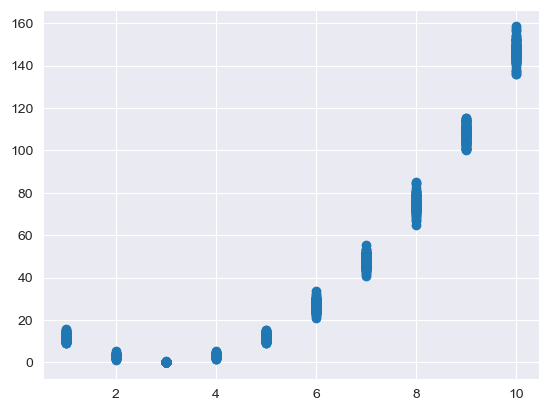

In [151]:
fig, ax0 = plt.subplots()
ax0.scatter(tested_ABC[:,0],tested_ABC[:,1])
fig.show()

In [152]:
X0 = [999, 1, 0]
gamma = 1
beta = 3
mu = 0
tstep = 0.05
test_time = 100
tmax = float(Decimal(tstep) * (Decimal(timed_sir(X0, mu, beta, gamma, test_time, rng) )/ Decimal(tstep)).quantize(1,rounding=ROUND_UP))
rng = np.random.default_rng(1)
print(tmax)
start_time = time.time()
reality = no_ext_sir(X0, mu, beta, gamma, tmax, tstep, rng)
print(f"Reality took {time.time() - start_time} seconds to run!")

11.0
Reality took 0.0530695915222168 seconds to run!


In [154]:
betas = np.arange(1,5,0.1)
def sim_sir(bet,model_rng):
    return no_ext_sir(X0, mu, bet, gamma, tmax, tstep, model_rng)
applied_ABC = ABC_core(sim_sir,betas,reality,1000,"sum_sq",rng)

In [155]:
print(applied_ABC)

[[1.00000000e+00 2.35483930e+08]
 [1.00000000e+00 2.47983948e+08]
 [1.00000000e+00 2.46866416e+08]
 ...
 [4.90000000e+00 1.86948860e+07]
 [4.90000000e+00 2.75551680e+07]
 [4.90000000e+00 2.29689400e+07]]


In [160]:
np.savetxt("../../Home made ABC Results/traj1.csv",applied_ABC,delimiter=",")

In [193]:
def ABC_rejection(epsilon,core_output):
    return core_output[core_output[:,1] <= epsilon]

In [211]:
thresholded_ABC = ABC_rejection(5e6,applied_ABC)

In [212]:
print(thresholded_ABC)

[[2.200000e+00 4.983384e+06]
 [2.200000e+00 4.637542e+06]
 [2.200000e+00 3.648130e+06]
 ...
 [4.900000e+00 2.359126e+06]
 [4.900000e+00 2.807202e+06]
 [4.900000e+00 2.701662e+06]]


In [215]:
result = pd.DataFrame(thresholded_ABC, columns=["Beta","Counts"])
bet_dis = result.groupby("Beta").count()

In [218]:
mles = np.genfromtxt("../../Data/R0_3/Fitted/MLE_b_I0_1_3.csv")
mle1 = mles[0]

C:\Users\ollie\AppData\Local\Temp\ipykernel_24680\3856519812.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


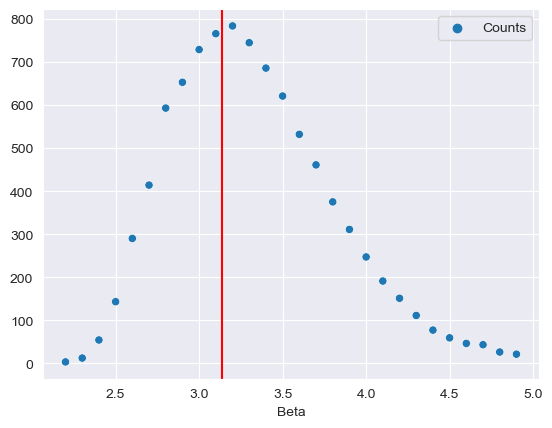

In [221]:
fig, ax0 = plt.subplots()
sns.scatterplot(bet_dis)
ax0.axvline(mle1, color = "red")
fig.show()